In [1]:
import pandas as pd

In [2]:
jobs = pd.read_csv('../data/updated_jobs.csv')

In [ ]:
servers_9204 = pd.read_csv('../data/servers_9204.csv')

In [19]:
servers_9204.head(2)

,Unnamed: 0,0,1,2,5,response_time,return_code,datetime,slurm_success,server
0,136,2020-10-16 08:34:42.779719,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",5.240251,0,2020-10-16 08:34:42.779719,1,ce5
1,198,2020-10-16 08:35:50.747136,user 9204,retry 0,"command ['/usr/bin/scontrol', 'show', 'job']",8.597585,0,2020-10-16 08:35:50.747136,1,ce5


In [43]:
servers_9204.size

612470

In [20]:
servers_9204 = servers_9204[servers_9204['5'].str.contains('sbatch')]
servers_9204.head(2)

,Unnamed: 0,0,1,2,5,response_time,return_code,datetime,slurm_success,server
0,136,2020-10-16 08:34:42.779719,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",5.240251,0,2020-10-16 08:34:42.779719,1,ce5
4,478,2020-10-16 08:53:15.711346,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.142444,0,2020-10-16 08:53:15.711346,1,ce5


In [24]:
odd_errors = servers_9204[(servers_9204['slurm_success']==0) & (servers_9204['response_time']<15)]
odd_errors.head(2)

,Unnamed: 0,0,1,2,5,response_time,return_code,datetime,slurm_success,server


In [38]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
jobs['BEGIN_dt'] = jobs['BEGIN_dt'].astype('datetime64[ns]')
jobs['END_dt'] = jobs['END_dt'].astype('datetime64[ns]')
jobs.dtypes

Unnamed: 0             int64
JOBID                 object
STATE                 object
BEGIN                 object
END                   object
REQMEM                object
USEDMEM               object
REQTIME               object
USEDTIME              object
NODES                  int64
CPUS                   int64
PARTITION             object
EXITCODE              object
BEGIN_dt      datetime64[ns]
END_dt        datetime64[ns]
dtype: object

In [33]:
jobs_filtered_by_completed = jobs[jobs['STATE'] == 'COMPLETED']
jobs_filtered_by_completed['end_dt_min_start'] = jobs_filtered_by_completed['END_dt'].dt.floor('min')
jobs_grouped = (
    jobs_filtered_by_completed.groupby('end_dt_min_start')['STATE']
    .count()
    .reset_index(name='total_completed_jobs')
)
jobs_grouped.head(2)

C:\Users\irela\AppData\Local\Temp\ipykernel_23480\3036749832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_filtered_by_completed['end_dt_min_start'] = jobs_filtered_by_completed['END_dt'].dt.floor('min')


,end_dt_min_start,total_completed_jobs
0,2020-10-01 00:10:00,1
1,2020-10-01 00:12:00,1


In [26]:
jobs.head(2)

,Unnamed: 0,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,BEGIN_dt,END_dt
0,0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0,2021-07-31 22:15:00,NaN
1,1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0,2021-08-06 11:36:09,2021-09-05 11:36:32


In [75]:
# Function to identify periods of success and failure
def identify_slurm_periods(dataframe=servers_9204, datetime_col='datetime', slurm_success_col='slurm_success', begin=None, end=None):
    
    """
    Identify periods of slurm_success and slurm_failure in a dataframe.
    
    Args:
    dataframe: pandas.DataFrame - The data containing the datetime and slurm_success columns.
    datetime_col: str - The name of the datetime column.
    slurm_success_col: str - The name of the slurm_success column.
    
    Returns:
    slurm_successes: list of tuples - Each tuple represents a start and end period of success.
    slurm_failures: list of tuples - Each tuple represents a start and end period of failure.
    """
    if begin!=None and end!=None:
        dataframe = dataframe[dataframe[datetime_col].between(begin, end)]

    dataframe = dataframe.sort_values(datetime_col).reset_index(drop=True)
    slurm_successes = []
    slurm_failures = []

    # Initialize tracking variables
    current_status = None
    start_time = None

    for i, row in dataframe.iterrows():
        status = row[slurm_success_col]
        time = row[datetime_col]

        if current_status is None:
            # Initialize the first status
            current_status = status
            start_time = time
        elif status != current_status:
            # Change in status detected, finalize the previous period
            if current_status == 1:
                slurm_successes.append((start_time, time))
            else:
                slurm_failures.append((start_time, time))
            
            # Update tracking variables for the new period
            current_status = status
            start_time = time

    # Append the last period
    if start_time is not None:
        if current_status == 1:
            slurm_successes.append((start_time, dataframe[datetime_col].iloc[-1]))
        else:
            slurm_failures.append((start_time, dataframe[datetime_col].iloc[-1]))

    return slurm_successes, slurm_failures

In [76]:
successes, failures = identify_slurm_periods()
print(successes[:2], failures[:2])

[('2020-10-16 08:34:42.779719', '2020-10-18 06:16:25.392946'), ('2020-10-18 06:16:36.503204', '2020-10-18 06:38:44.172473')] [('2020-10-18 06:16:25.392946', '2020-10-18 06:16:36.503204'), ('2020-10-18 06:38:44.172473', '2020-10-18 06:38:47.662814')]


In [77]:
my_successes, my_failures = identify_slurm_periods(begin='2021-10-07 12:00:00', end='2021-10-08 12:00:00')
print(my_successes[:2], my_failures[:2])

[('2021-10-07 12:00:27.355393', '2021-10-07 22:00:20.919558')] []


In [78]:
def jobs_and_servers_between_dates_9204(begin_date, end_date):
    jobs_grouped_specified_date_frame = jobs_grouped.loc[jobs_grouped['end_dt_min_start'].between(begin_date, end_date)]
    jobs_grouped_specified_date_frame['total_completed_jobs'] = jobs_grouped_specified_date_frame['total_completed_jobs'].apply(lambda x: x/100)

    x=jobs_grouped_specified_date_frame['end_dt_min_start']
    y=jobs_grouped_specified_date_frame['total_completed_jobs']
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, color='red', alpha=.5)
    plt.title(f'Total jobs completed between {begin_date} and {end_date}', fontsize=14)
    plt.xlabel('Minute Start', fontsize=12)
    plt.ylabel('Total jobs completed (red)', fontsize=12)
    plt.grid(True)
    plt.tight_layout();

C:\Users\irela\AppData\Local\Temp\ipykernel_23480\2682757374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_grouped_specified_date_frame['total_completed_jobs'] = jobs_grouped_specified_date_frame['total_completed_jobs'].apply(lambda x: x/100)


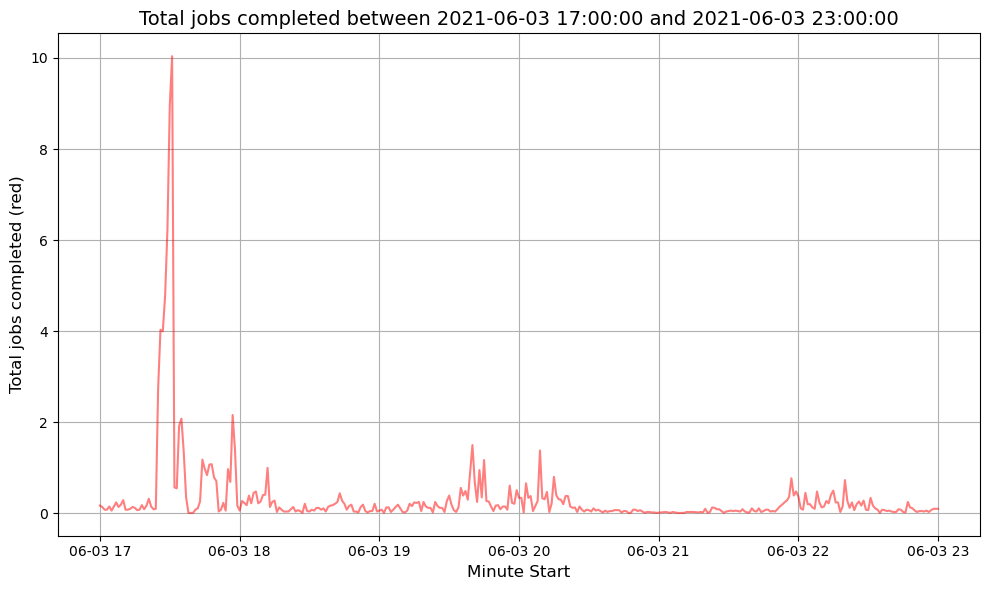

In [68]:
jobs_and_servers_between_dates_9204('2021-06-03 17:00:00', '2021-06-03 23:00:00')

In [164]:
def plot_jobs_and_servers_with_slurm_periods(
    dataframe=servers_9204, datetime_col='datetime', slurm_success_col='slurm_success', rolling=0,
    begin_date=None, end_date=None, jobs_grouped=jobs_grouped, jobs_datetime_col='end_dt_min_start', jobs_metric_col='total_completed_jobs'
): 

    if begin_date and end_date:
        # Filter slurm dataframe for the specified date range
        slurm_filtered = dataframe[(dataframe[datetime_col] >= begin_date) & (dataframe[datetime_col] <= end_date)]
        
        # Identify slurm success and failure periods
        success_regions, failure_regions = identify_slurm_periods(slurm_filtered, datetime_col, slurm_success_col)
        
        # Filter jobs dataframe for the specified date range
        jobs_filtered = jobs_grouped[jobs_grouped[jobs_datetime_col].between(begin_date, end_date)]
        jobs_filtered[jobs_metric_col] = jobs_filtered[jobs_metric_col]
        
        # Extract x and y for plotting
        x = jobs_filtered[jobs_datetime_col]
        y = jobs_filtered[jobs_metric_col]
        
        plt.figure(figsize=(12, 8))
        plt.plot(x, y, color='red', alpha=0.7, label='Total Completed Jobs')
        if rolling > 0:
            plt.plot(x, y.rolling(rolling).mean(), color='black', alpha=.7, label='Rolling Average')
        # Add slurm success regions
        for start, end in success_regions:
            plt.axvspan(start, end, color='green', alpha=0.3)
        
        # Add slurm failure regions
        for start, end in failure_regions:
            plt.axvspan(start, end, color='red', alpha=0.3)
        
        # Add a single legend for success and failure regions
        green_patch = plt.Line2D([0], [0], color='green', lw=4, alpha=0.3, label='Slurm Success Period')
        red_patch = plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label='Slurm Failure Period')
        handles = [
            plt.Line2D([0], [0], color='green', lw=4, alpha=0.3, label='Slurm Success Period'),
            plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label='Slurm Failure Period'),
            plt.Line2D([0], [0], color='red', label='Total Completed Jobs')
        ]

        if rolling > 0:
            handles.append(plt.Line2D([0], [0], color='black', label=f'Total Completed Jobs (Rolling {rolling} min Average)'))

        # Add the legend
        plt.legend(handles=handles, loc='upper left')
        plt.title(f'Total Jobs Completed and Slurm Periods ({begin_date} to {end_date})', fontsize=14)
        plt.xlabel('Datetime', fontsize=12)
        plt.ylabel('Jobs Completed', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show();
    else:
        raise ValueError('Need begin_date and end_date.')


C:\Users\irela\AppData\Local\Temp\ipykernel_23480\1261529778.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_filtered[jobs_metric_col] = jobs_filtered[jobs_metric_col]


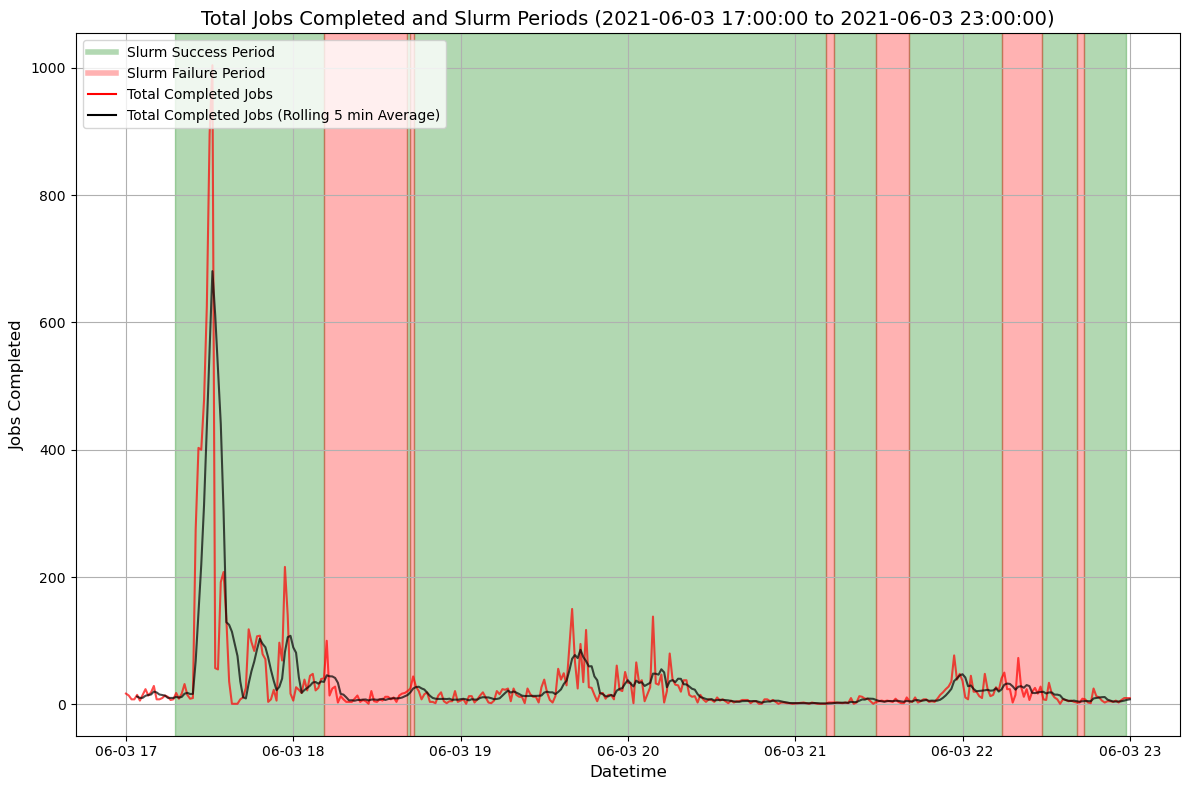

In [167]:
plot_jobs_and_servers_with_slurm_periods(begin_date='2021-06-03 17:00:00', end_date='2021-06-03 23:00:00', rolling=5)

C:\Users\irela\AppData\Local\Temp\ipykernel_23480\792858145.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_filtered[jobs_metric_col] = jobs_filtered[jobs_metric_col]


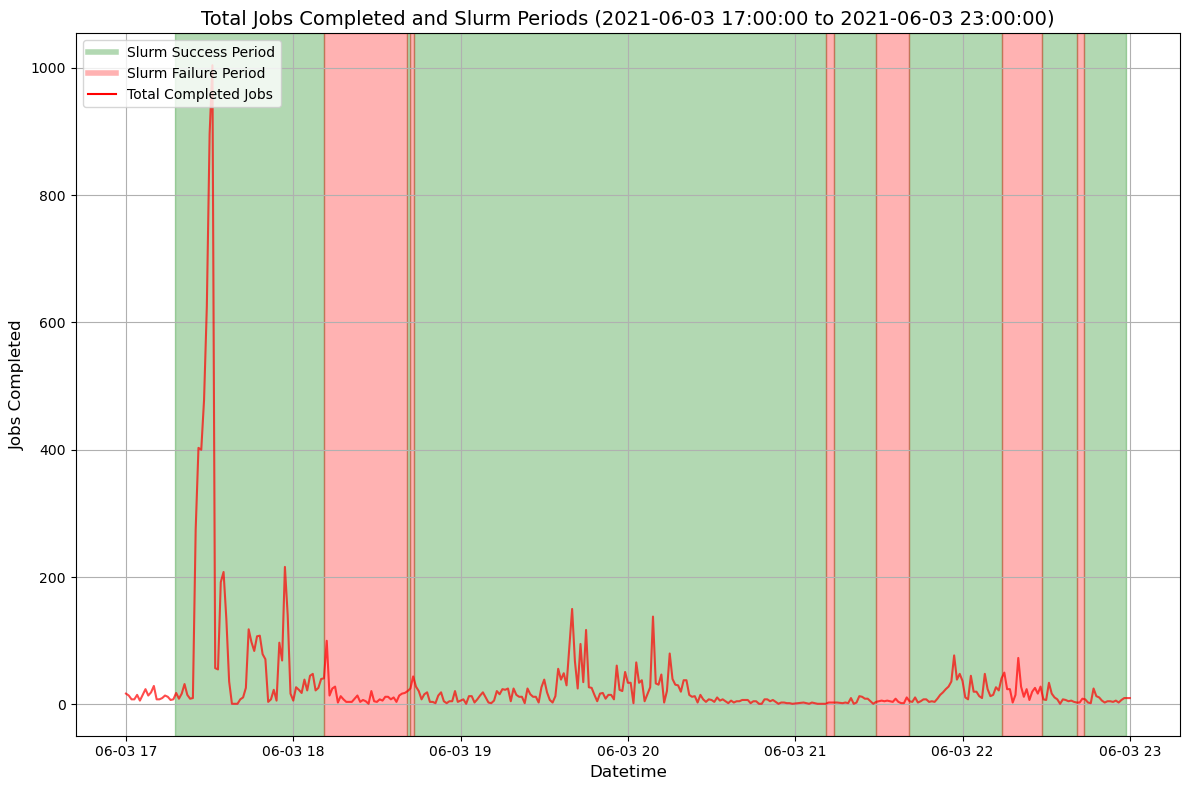

In [79]:
plot_jobs_and_servers_with_slurm_periods(begin_date='2021-06-03 17:00:00', end_date='2021-06-03 23:00:00')

In [94]:
servers_9204['datetime'] = servers_9204['datetime'].astype('datetime64[ns]')

In [105]:
servers_9204.size

673717

In [104]:
servers_9204.head(2)

,Unnamed: 0,0,1,2,5,response_time,return_code,datetime,slurm_success,server,dt_min_start
0,136,2020-10-16 08:34:42.779719,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",5.240251,0,2020-10-16 08:34:42.779719,1,ce5,2020-10-16 08:34:00
4,478,2020-10-16 08:53:15.711346,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.142444,0,2020-10-16 08:53:15.711346,1,ce5,2020-10-16 08:53:00


In [144]:
servers_filtered = servers_9204
servers_filtered['dt_min_start'] = servers_filtered['datetime'].dt.floor('min')

# Grouping by 'dt_min_start'
servers_grouped = servers_filtered.groupby('dt_min_start')

# Displaying the first 2 rows of each group
servers_grouped.head(1)


,Unnamed: 0,0,1,2,5,response_time,return_code,datetime,slurm_success,server,dt_min_start
0,136,2020-10-16 08:34:42.779719,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",5.240251,0,2020-10-16 08:34:42.779719,1,ce5,2020-10-16 08:34:00
4,478,2020-10-16 08:53:15.711346,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.142444,0,2020-10-16 08:53:15.711346,1,ce5,2020-10-16 08:53:00
11,670,2020-10-16 09:04:56.472464,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.066345,0,2020-10-16 09:04:56.472464,1,ce5,2020-10-16 09:04:00
18,826,2020-10-16 09:24:26.694758,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.072883,0,2020-10-16 09:24:26.694758,1,ce5,2020-10-16 09:24:00
19,923,2020-10-16 09:34:24.594440,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.076409,0,2020-10-16 09:34:24.594440,1,ce5,2020-10-16 09:34:00
...,...,...,...,...,...,...,...,...,...,...,...
314680,4776236,2021-10-07 21:00:21.304501,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.024102,0,2021-10-07 21:00:21.304501,1,ce6,2021-10-07 21:00:00
314687,4776301,2021-10-07 21:09:18.877704,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.098236,0,2021-10-07 21:09:18.877704,1,ce6,2021-10-07 21:09:00
314694,4776410,2021-10-07 21:30:31.591816,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.030386,0,2021-10-07 21:30:31.591816,1,ce6,2021-10-07 21:30:00
314702,4776444,2021-10-07 21:39:15.524139,user 9204,retry 0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",0.033684,0,2021-10-07 21:39:15.524139,1,ce6,2021-10-07 21:39:00


In [102]:
servers_grouped['total_successful_jobs'].value_counts()

total_successful_jobs
1    44208
2     7023
3      778
4      127
5       25
6        3
8        1
Name: count, dtype: int64

C:\Users\irela\AppData\Local\Temp\ipykernel_23480\792858145.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_filtered[jobs_metric_col] = jobs_filtered[jobs_metric_col]


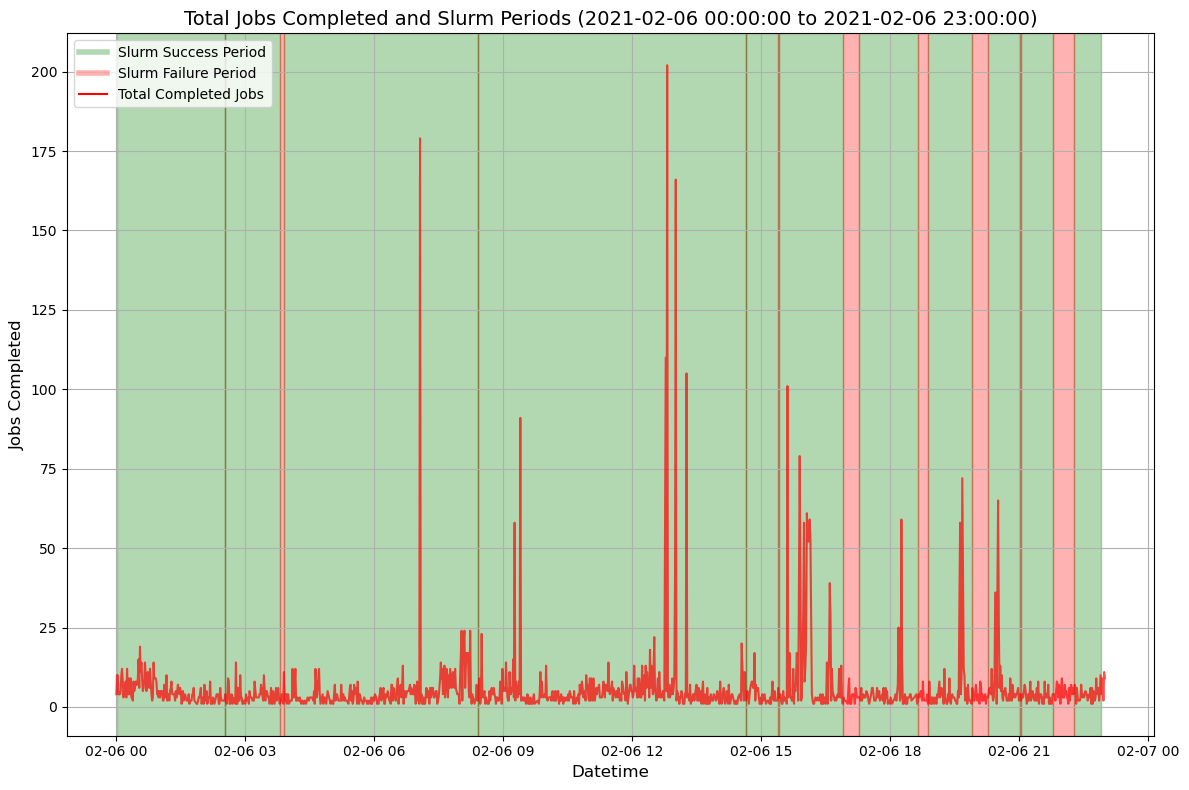

In [81]:
plot_jobs_and_servers_with_slurm_periods(begin_date='2021-02-06 00:00:00', end_date='2021-02-06 23:00:00')

In [89]:
jobs_grouped['total_completed_jobs'].sort_values(ascending=False)

322102    1004
9312       911
9402       898
322101     896
196138     823
          ... 
311187       1
311182       1
311181       1
311178       1
489150       1
Name: total_completed_jobs, Length: 489151, dtype: int64

In [115]:
import statsmodels.formula.api as smf

In [116]:
return_code_jobs_completed_logit = smf.logit('slurm_success ~ response_time',
                    data = servers_9204).fit()
# for extended/future studies, we can also look at the additional independent factor of # of jobs user 4209 submitted on SLURM

Optimization terminated successfully.
         Current function value: 0.016147
         Iterations 15


In [117]:
return_code_jobs_completed_logit.params

Intercept        39.450069
response_time    -2.100644
dtype: float64

In [118]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [124]:
r_time = 5
pred = return_code_jobs_completed_logit.params['Intercept'] + return_code_jobs_completed_logit.params['response_time']*r_time
print(logistic(pred))

0.9999999999997318
